In [3]:
#imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_predict,
                                     cross_validate, train_test_split)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import statistics
import shap
from sksurv.ensemble import RandomSurvivalForest
from lifelines import KaplanMeierFitter

from lifelines.statistics import logrank_test

random_state = 42

In [4]:
#ds loading and variables removal 
ds = pd.read_csv(r"C:\Users\USER\OneDrive\Summer_project\Azure\annex study\ds_annex_study.csv", index_col = 'ID')
ds = ds.drop(columns=['date','DOB', 'preexisting_cond', 'twoyears', 'fiveyears', 'death'])


In [5]:
#Extra preprocessing (1-hot encoding)
ds = ds.fillna(ds.mean())
ds = ds.fillna(0)


for variable in ['COPD', 'ILD', 'NTM']:
    ds[variable][ds[variable] == 'Yes'] = 1
    ds[variable][ds[variable] == 'No'] = 0

ds['sex'][ds['sex'] == 'F'] = 0
ds['sex'][ds['sex'] == 'M'] = 1

ds.ethnicity = ds.ethnicity.astype('category').cat.codes

labels2 = ds['dead2']
labels5 = ds['dead5']

ds = ds.drop(columns = ['dead2'])

counter2 = Counter(labels2)
counter5 = Counter(labels5)

print('2 years', counter2)
print('5 years', counter5)

counter = counter5

# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
estimate2 = counter[1]/counter[0]

#dataset split 
X_train, X_test, y_train, y_test = train_test_split(ds, labels2, test_size=0.2, shuffle = True, random_state=random_state)
features = ds.columns
# ds = np.array(ds)
# labels2 = np.array(labels2)


2 years Counter({0: 61, 1: 24})
5 years Counter({0: 46, 1: 39})


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [6]:
SHAP = True

# model = RandomForestClassifier(random_state=random_state, class_weight = {0:estimate2, 1:estimate})
# model = XGBClassifier(random_state=random_state, scale_pos_weight = estimate)
# model = XGBClassifier(random_state=random_state, scale_pos_weight = estimate)
model = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
# model = LogisticRegression(random_state = random_state)
labels = labels5

#model training
skf = KFold(n_splits=5, random_state=random_state, shuffle=True)
acc = []
cms = []
f1 = []

for train_index, test_index in skf.split(ds, labels):
    X_train, X_test = ds[train_index], ds[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print(X_test)
    xgbc = model
    xgbc.fit(X_train, y_train)
    y_pred = xgbc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cf = confusion_matrix(y_test, y_pred)
    fscore = f1_score(y_test, y_pred)
    acc.append(accuracy)
    cms.append(cf)
    f1.append(fscore)
    print('Accuracy:', round(accuracy,2))
    print('F1-score:', round(fscore,2))
    print('Confusion matrix:\n', cf)

    if SHAP:
        ex = shap.Explainer(model)
        shaps_values = ex.shap_values(X_test)
        plt.figure(figsize = (15,15))
        shap.summary_plot(shaps_values, pd.DataFrame(X_test.astype('float'), columns = features), show = True)
        plt.savefig('SHAP_CPA.png',bbox_inches='tight', dpi=300)
        SHAP = False

print('Averaged accuracy (5-folds): %.3f ±  %.3f' % (np.mean(acc), statistics.stdev(acc)))
print('Averaged f1-score (5-folds): %.3f ±  %.3f' % (np.mean(f1), statistics.stdev(f1)))



KeyError: "None of [Int64Index([ 1,  2,  3,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 19, 20, 21,\n            23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 38, 39, 41, 42,\n            43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62,\n            63, 64, 65, 67, 69, 70, 71, 73, 74, 75, 76, 77, 79, 80, 81, 83,\n            84],\n           dtype='int64')] are in the [columns]"

In [10]:
###COPD 
plt.style.use(['seaborn-paper', 'seaborn-dark', 'seaborn-colorblind'])
kmf_1 = KaplanMeierFitter()
kmf_0 = KaplanMeierFitter()

pos = ds.query('COPD == 1')
neg = ds.query('COPD == 0')

T1 = pos.surv
E1 = pos.dead5

T2 = neg.surv
E2 = neg.dead5

results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
print(print(results.p_value))

kmf_1.fit(durations =  pos["surv"],event_observed = pos["dead5"] ,label="COPD")
kmf_0.fit(durations =  neg["surv"],event_observed = neg["dead5"], label="No COPD")
# print (kmf_1.event_table)
# print (kmf_0.event_table)

# print (kmf_1.predict(11))
# print (kmf_0.predict(11))

# print (kmf_1.survival_function_)
# print (kmf_0.survival_function_)

# Plot the survival_function data :
# kmf_1.plot()
# kmf_0.plot()
print (kmf_0.cumulative_density_at_times(730))
print (kmf_1.cumulative_density_at_times(730))

print (kmf_0.cumulative_density_at_times(1825))
print (kmf_1.cumulative_density_at_times(1825))
fig, ax = plt.subplots()

plt.xlabel("Days passed")
plt.ylabel("Dying probability")



kmf_1.plot_cumulative_density()
kmf_0.plot_cumulative_density()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
legend = ax.legend(loc='lower right')


AttributeError: 'DataFrame' object has no attribute 'dead2'

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
0.05755309590597476
None
730    0.220339
Name: No ILD, dtype: float64
730    0.423077
Name: ILD, dtype: float64
1825    0.442747
Name: No ILD, dtype: float64
1825    0.678571
Name: ILD, dtype: float64


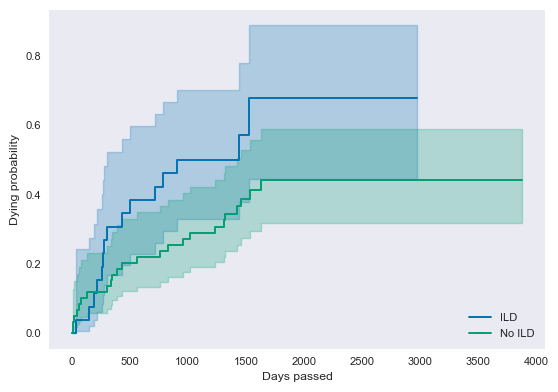

In [11]:
###ILD 
print(plt.style.available)
plt.rcdefaults() 
plt.style.use(['seaborn-paper', 'seaborn-dark', 'seaborn-colorblind'])

kmf_1 = KaplanMeierFitter()
kmf_0 = KaplanMeierFitter()

pos = ds.query('ILD == 1')
neg = ds.query('ILD == 0')

T1 = pos.surv
E1 = pos.dead5

T2 = neg.surv
E2 = neg.dead5

results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
print(print(results.p_value))

kmf_1.fit(durations =  pos["surv"],event_observed = pos["dead5"] ,label="ILD")
kmf_0.fit(durations =  neg["surv"],event_observed = neg["dead5"], label="No ILD")
# print (kmf_1.event_table)
# print (kmf_0.event_table)

# print (kmf_1.predict(11))
# print (kmf_0.predict(11))
print (kmf_0.cumulative_density_at_times(730))
print (kmf_1.cumulative_density_at_times(730))

print (kmf_0.cumulative_density_at_times(1825))
print (kmf_1.cumulative_density_at_times(1825))

# print (kmf_1.survival_function_)
# print (kmf_0.survival_function_)

# Plot the survival_function data :
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



kmf_1.plot_cumulative_density()
kmf_0.plot_cumulative_density()
plt.xlabel("Days passed")
plt.ylabel("Dying probability")
legend = ax.legend(loc='lower right')
ax.grid(False)


In [12]:
###NTM 
# print(plt.style.available)
plt.style.use(['seaborn-paper', 'seaborn-dark', 'seaborn-colorblind'])
kmf_1 = KaplanMeierFitter()
kmf_0 = KaplanMeierFitter()

pos = ds.query('NTM == 1')
neg = ds.query('NTM == 0')

T1 = pos.surv
E1 = pos.dead5

T2 = neg.surv
E2 = neg.dead5

results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
print(print(results.p_value))


kmf_1.fit(durations =  pos["surv"],event_observed = pos["dead5"] ,label="NTM")
kmf_0.fit(durations =  neg["surv"],event_observed = neg["dead5"], label="No NTM")
# print (kmf_1.event_table)
# print (kmf_0.event_table)

# print (kmf_1.predict(11))
# print (kmf_0.predict(11))
np.set_printoptions(threshold=1000)
# print (kmf_0.survival_function_)
print (kmf_0.cumulative_density_at_times(730))
print (kmf_1.cumulative_density_at_times(730))

print (kmf_0.cumulative_density_at_times(1825))
print (kmf_1.cumulative_density_at_times(1825))

# print (kmf_0.survival_function_)

# # Plot the survival_function data :
# fig, ax = plt.subplots()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# # plt.title("KMF")

# kmf_1.plot_cumulative_density()
# kmf_0.plot_cumulative_density()
# plt.xlabel("Days passed")
# plt.ylabel("Dying probability")
# legend = ax.legend(loc='lower right')
# ax.grid(False)


0.7566244856030546
None
730    0.238095
Name: No NTM, dtype: float64
730    0.409091
Name: NTM, dtype: float64
1825    0.516093
Name: No NTM, dtype: float64
1825    0.458333
Name: NTM, dtype: float64


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
0.45711888247512333
None
730    0.267857
Name: Not bilateral, dtype: float64
730    0.310345
Name: Bilateral, dtype: float64
1825    0.463503
Name: Not bilateral, dtype: float64
1825    0.606101
Name: Bilateral, dtype: float64


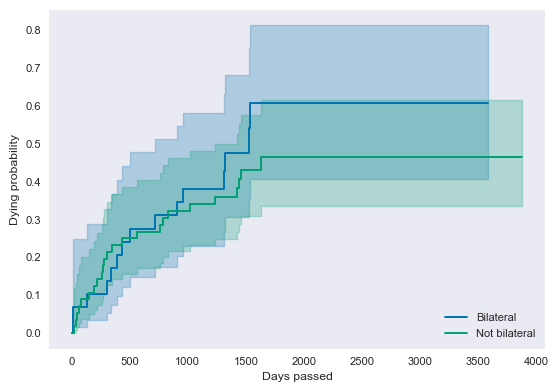

In [13]:
###NTM 
print(plt.style.available)
plt.style.use(['seaborn-paper', 'seaborn-dark', 'seaborn-colorblind'])
kmf_1 = KaplanMeierFitter()
kmf_0 = KaplanMeierFitter()

pos = ds.query('summary == 1')
neg = ds.query('summary == 0')
T1 = pos.surv
E1 = pos.dead5

T2 = neg.surv
E2 = neg.dead5

results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
print(print(results.p_value))
kmf_1.fit(durations =  pos["surv"],event_observed = pos["dead5"] ,label="Bilateral")
kmf_0.fit(durations =  neg["surv"],event_observed = neg["dead5"], label="Not bilateral")
# print (kmf_1.event_table)
# print (kmf_0.event_table)

# print (kmf_1.predict(11))
# print (kmf_0.predict(11))

# print (kmf_1.survival_function_)
# print (kmf_0.survival_function_)
print (kmf_0.cumulative_density_at_times(730))
print (kmf_1.cumulative_density_at_times(730))

print (kmf_0.cumulative_density_at_times(1825))
print (kmf_1.cumulative_density_at_times(1825))

# Plot the survival_function data :
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



# plt.title("KMF")

kmf_1.plot_cumulative_density()
kmf_0.plot_cumulative_density()
plt.xlabel("Days passed")
plt.ylabel("Dying probability")
legend = ax.legend(loc='lower right')
ax.grid(False)


In [15]:
#COX hazard model with or without CT scan data

from lifelines import CoxPHFitter
data_full = ds.drop(columns = ['BR', 'ER'])
data_no_ct = ds.drop(columns = ['FL', 'FB', 'SB', 'BB', 'BR', 'BL', 'ER', 'EB', 'GR', 'GL', 'GB',
       'CB', 'CR', 'CL', 'cavities', 'fungal_balls', 
       'summary'])




cph_full = CoxPHFitter()
cph_full.fit(data_full,"surv",event_col="dead5")
cph_full.print_summary()


cph_no_ct = CoxPHFitter()
cph_no_ct.fit(data_no_ct,"surv",event_col="dead5")
cph_no_ct.print_summary()



# # Plot the survival function :
# d_data = data_full.iloc[0:5,:]
# cph.predict_survival_function(d_data).plot()



Column FL have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['dead5'].astype(bool)
>>> print(df.loc[events, 'FL'].var())
>>> print(df.loc[~events, 'FL'].var())

A very low variance means that the column FL completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.672. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?



<lifelines.CoxPHFitter: fitted with 85 total observations, 46 right-censored observations>
             duration col = 'surv'
                event col = 'dead5'
      baseline estimation = breslow
   number of observations = 85
number of events observed = 39
   partial log-likelihood = -139.51
         time fit was run = 2022-08-26 16:20:32 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
sex            0.76       2.14       0.48            -0.18             1.70                 0.83                 5.49
age            0.04       1.04       0.02             0.01             0.08                 1.01                 1.08
ethnicity      0.10       1.10       0.10            -0.10             0.29                 0.90                 1.34
crp            0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
albumin       -0.03       0.97       0.06            -0.14             0.08                 0.87                 1.08
BMI           -0.08       0.92       0.08            -0.23             0.07                 0.79                 1.07
COPD          -0.27       0.76       0.56            -1.37             0.82                 0.25                 2.27
ILD            1.75       5.74       0.81             0.16             3.33                 1.18                28.00
NTM            0.32       1.38       0.49            -0.64             1.28                 0.53                 3.58
FL            -2.90       0.06       1.71            -6.26             0.46                 0.00                 1.58
FB             0.29       1.34       0.80            -1.28             1.86                 0.28                 6.43
SB            -2.44       0.09       1.08            -4.55            -0.33                 0.01                 0.72
BB             1.24       3.45       0.62             0.03             2.45                 1.03                11.61
BL            -1.11       0.33       0.98            -3.03             0.80                 0.05                 2.23
EB             0.48       1.62       0.54            -0.58             1.55                 0.56                 4.69
GR             2.05       7.80       0.97             0.15             3.96                 1.16                52.32
GL             3.22      25.15       1.57             0.15             6.30                 1.16               546.99
GB            -0.27       0.77       0.94            -2.12             1.58                 0.12                 4.88
CB            -0.30       0.74       0.55            -1.39             0.78                 0.25                 2.19
CR             0.24       1.27       0.56            -0.86             1.33                 0.42                 3.79
CL             0.20       1.22       0.66            -1.09             1.50                 0.34                 4.48
cavities      18.66   1.27e+08    2676.61         -5227.39          5264.72                 0.00                  inf
fungal_balls   0.04       1.04       0.86            -1.64             1.72                 0.19                 5.61
summary      -18.28       0.00    2676.61         -5264.33          5227.78                 0.00                  inf

               cmp to     z    p   -log2(p)
covariate                                  
sex              0.00  1.58 0.11       3.14
age              0.00  2.48 0.01       6.25
ethnicity        0.00  0.94 0.35       1.53
crp              0.00  2.21 0.03       5.22
albumin          0.00 -0.59 0.55       0.86
BMI              0.00 -1.07 0.29       1.81
COPD             0.00 -0.49 0.62       0.68
ILD              0.00  2.16 0.03       5.03
NTM              0.00  0.66 0.51       0.97
FL               0.00 -1.69 0.09       3.46
FB               0.00  0.36 0.72       0.48
SB    

<lifelines.CoxPHFitter: fitted with 85 total observations, 46 right-censored observations>
             duration col = 'surv'
                event col = 'dead5'
      baseline estimation = breslow
   number of observations = 85
number of events observed = 39
   partial log-likelihood = -148.10
         time fit was run = 2022-08-26 16:20:32 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.37       1.45       0.36            -0.33             1.08                 0.72                 2.95
age         0.03       1.03       0.01             0.00             0.06                 1.00                 1.06
ethnicity   0.09       1.10       0.07            -0.04             0.22                 0.96                 1.25
crp         0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
albumin    -0.07       0.93       0.04            -0.16             0.01                 0.85                 1.01
BMI        -0.05       0.95       0.06            -0.16             0.06                 0.85                 1.06
COPD       -0.17       0.84       0.46            -1.08             0.73                 0.34                 2.07
ILD         1.03       2.80       0.42             0.20             1.86                 1.22                 6.44
NTM         0.29       1.34       0.42            -0.52             1.11                 0.59                 3.03

            cmp to     z    p   -log2(p)
covariate                               
sex           0.00  1.03 0.30       1.73
age           0.00  2.23 0.03       5.28
ethnicity     0.00  1.37 0.17       2.54
crp           0.00  2.40 0.02       5.95
albumin       0.00 -1.68 0.09       3.44
BMI           0.00 -0.93 0.35       1.50
COPD          0.00 -0.38 0.71       0.50
ILD           0.00  2.43 0.02       6.04
NTM           0.00  0.70 0.48       1.05
---
Concordance = 0.71
Partial AIC = 314.20
log-likelihood ratio test = 22.59 on 9 df
-log2(p) of ll-ratio test = 7.12

In [19]:
from lifelines import CoxPHFitter

print(data_full.columns)
data_no_ct = ds.drop(columns=['sex','age', 'ethnicity',  'albumin', 'BMI', 'COPD', 'BR', 'ER', 'crp',  'ILD',
        'FL', 'FB', 'SB', 'BB', 'BL', 'EB', 'GR', 'GL', 'GB', 'CB', 'CR',
       'CL', 'cavities', 'fungal_balls', 'summary'])




cph_full = CoxPHFitter()
cph_full.fit(data_no_ct,"surv",event_col="dead5")
cph_full.print_summary()

Index(['sex', 'age', 'ethnicity', 'crp', 'albumin', 'BMI', 'COPD', 'ILD',
       'NTM', 'FL', 'FB', 'SB', 'BB', 'BL', 'EB', 'GR', 'GL', 'GB', 'CB', 'CR',
       'CL', 'cavities', 'fungal_balls', 'summary', 'dead5', 'surv'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 85 total observations, 46 right-censored observations>
             duration col = 'surv'
                event col = 'dead5'
      baseline estimation = breslow
   number of observations = 85
number of events observed = 39
   partial log-likelihood = -159.13
         time fit was run = 2022-08-26 16:30:18 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
summary     0.24       1.28       0.33            -0.40             0.89                 0.67                 2.44

            cmp to    z    p   -log2(p)
covariate                              
summary       0.00 0.74 0.46       1.13
---
Concordance = 0.52
Partial AIC = 320.25
log-likelihood ratio test = 0.54 on 1 df
-log2(p) of ll-ratio test = 1.11